In [1]:
# Clone the diffusion model into our colab environment
!git clone https://github.com/lucidrains/denoising-diffusion-pytorch.git
%cd denoising-diffusion-pytorch/
!pip install -e .

Cloning into 'denoising-diffusion-pytorch'...
remote: Enumerating objects: 1884, done.
remote: Total 1884 (delta 0), reused 0 (delta 0), pack-reused 1884 (from 1)
Receiving objects: 100% (1884/1884), 2.57 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (1336/1336), done.
/content/denoising-diffusion-pytorch
Obtaining file:///content/denoising-diffusion-pytorch
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 986.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Get the imports; check if the gpu is available

import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import os
import numpy as np
from PIL import Image
from datetime import datetime
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import matplotlib.pyplot as plt
import pandas as pd
import io
import re
import struct

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

print(f"Imports finished at {datetime.now()}")

Can I can use GPU now? -- False
Imports finished at 2025-04-12 17:23:54.879160


In [11]:
# Load your data set; This function is used to save off MNIST images back to pngs
imagesToSave = 5000

def save_images_from_dataloader(dataloader, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    saved = 0

    # Iterate over the DataLoader
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Iterate over each image in the batch
        for i in range(images.size(0)):
            # Get the image tensor and convert it to a numpy array
            img_tensor = images[i]
            img_array = img_tensor.numpy()

            # Rescale the image array to [0, 255] and convert to uint8
            img_array = (img_array * 255).astype(np.uint8)
            #print(img_array.shape)

            # Convert the numpy array to a PIL Image
            img = Image.fromarray(img_array[0], mode='L')  # 'L' mode for grayscale images

            # Define the file path and save the image
            file_path = os.path.join(output_folder, f'image_{batch_idx * dataloader.batch_size + i}.png')
            img.save(file_path)
            #print(f'Saved {file_path}')
            saved += 1

            # Only save some as this will take a while to train
            if saved >= imagesToSave:
                return


In [4]:
# Load MNist

batch_size = 32
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


print(train_dataset)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.43MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 162kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.07MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [12]:
# NOTE: Skip this step if you have already generated the images folder

# Specify the output folder
output_folder = './mnist_images'

# Save the images from the DataLoader
save_images_from_dataloader(train_loader, output_folder)

print(f"MNIST Images made at time: {datetime.now()}")

MNIST Images made at time: 2025-04-12 17:50:44.726273


In [6]:
# Use this cell to train;

# NOTE: On these settings, training will take a while. To generate results in a reasonable time, decrease the timesteps in diffusion and the train_num_steps in trainer. However results will likely be low quality
# NOTE: If you want the model to work well, you have put in the time to train it, sufficient training takes many hours

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4),
    channels = 1
)

diffusion = GaussianDiffusion(
    model,
    image_size = 28,
    timesteps = 1000    # Decrease this to speed up; quality will supper
)

trainer = Trainer(
    diffusion,
    output_folder,
    train_batch_size = batch_size,
    train_lr = 2e-4,
    train_num_steps = 100000,  # Decrease this to speed up; quality will suffer
    gradient_accumulate_every = 2,
    ema_decay = 0.995,
    amp = True,
    calculate_fid = False
)

trainer.train()

print(f"Training time finished: {datetime.now()}")

  0%|          | 0/100 [00:00<?, ?it/s]

training complete
Training time finished: 2025-04-12 17:43:03.867083


In [13]:
# Used to cleanup MNIST data; if running locally
import shutil
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
else:
    print(f"The directory: {output_folder} does not exist")

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 1, 28, 28])


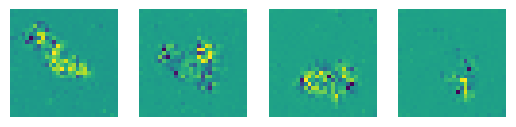

Images generated at: 2025-04-12 17:43:31.373400


In [8]:
# Generate sample images

samples = diffusion.sample(batch_size = 4)
print(samples.shape) # (4, 1, 28, 28)

for i, sample in enumerate(samples):
  plt.subplot(1, 4, i + 1)
  plt.imshow(sample.permute(1, 2, 0).cpu().numpy())
  plt.axis("off")

plt.show()

print(f"Images generated at: {datetime.now()}")